In [78]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



In [79]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [80]:

#load pretrained model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

#modify output layer for 2 classes - for this case the classes are regular frogs and noisy frogs
#but for the project it would be poisoned vs non-poisoned images
model.fc = torch.nn.Linear(num_ftrs, 2)


In [81]:
#freeze earlier layers - this is optional and it may work better to NOT freeze the earlier layers
for param in model.parameters():
    param.requires_grad = False
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True 


In [82]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [83]:
trainset = torchvision.datasets.ImageFolder(root="data/frogs/train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root="data/frogs/train",transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

EPOCHS=40
BATCH_SIZE = 32
TOTAL_SIZE = 4900 + 500
#TOTAL_TEST_SIZE = 
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE

TOTAL_TEST_SIZE = 200 
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE

In [84]:
trainset

Dataset ImageFolder
    Number of datapoints: 5409
    Root location: data/frogs/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [85]:
trainset.classes

['clean', 'poison']

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.008
)  # lr should be kept low so that the pre-trained weights don't change easily

In [87]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(testloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            for i in range(BATCH_SIZE):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )

In [88]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 105 INCORRECT: 87 TEST ACCURACY: 0.546875
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.546875 LOSS : 0.7246945897738138


In [94]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []


loss_history = []
accuracy_history = []

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        for p in range(BATCH_SIZE):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model.state_dict(), "model_save/model.pth") # Saving our best model

-----------------------EPOCH 0 -----------------------------------
 EPOCH 0 MINIBATCH: 167/168 LOSS: tensor(0.7136, device='cuda:0') 
 EPOCH 0 LOSS tensor(0.5144, device='cuda:0') ETA: 1.533475637435913 
 MAX LOSS: tensor(1.9138, device='cuda:0') MIN LOSS: tensor(0.0224, device='cuda:0') TRAIN ACCURACY: 0.8688616071428571
CORRECT: 163 INCORRECT: 29 TEST ACCURACY: 0.8489583333333334
-----------------------EPOCH 1 -----------------------------------
 EPOCH 1 MINIBATCH: 167/168 LOSS: tensor(0.2001, device='cuda:0') 
 EPOCH 1 LOSS tensor(0.5481, device='cuda:0') ETA: 1.4132304191589355 
 MAX LOSS: tensor(1.9535, device='cuda:0') MIN LOSS: tensor(0.0049, device='cuda:0') TRAIN ACCURACY: 0.8643973214285714
CORRECT: 165 INCORRECT: 27 TEST ACCURACY: 0.859375
-----------------------EPOCH 2 -----------------------------------
 EPOCH 2 MINIBATCH: 167/168 LOSS: tensor(0.5607, device='cuda:0') 
 EPOCH 2 LOSS tensor(0.5099, device='cuda:0') ETA: 1.375591516494751 
 MAX LOSS: tensor(1.8056, device='c

In [90]:
# Summary after training
print("\nTraining complete.")
print(f"Best Test Accuracy: {new_best:.4f}")


Training complete.
Best Test Accuracy: 0.9479


In [91]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
from PIL import Image
clean_count = 0
poisoned_count = 0
dataset_path = os.path.expanduser("~/demo/poison/ASPARaGUS/allfrog/")
with open('classification_results.txt', 'w') as file:
    for image_name in os.listdir(dataset_path):
        image_path = os.path.join(dataset_path, image_name)

        # Skip non-image files
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        input_tensor = input_tensor.to(device)

        # Predict with the model
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()

        # Categorize the image based on the prediction
        if predicted_class == 0:  # Replace 0 with the "clean" class index
            clean_count += 1
            result = "good"
        else:  # Assume all other classes are "poisoned"
            poisoned_count += 1
            result = "bad"

        # Write the result to the text file
        file.write(f"{result}\n")

        # Optionally print the classification for each image
        print(f"Image {image_name} classified as {'good' if result == 'good' else 'bad'}.")

Image 70.png classified as good.
Image 4961.png classified as good.
Image 4109.png classified as good.
Image 2286.png classified as good.
Image 518.png classified as good.
Image 5118.png classified as good.
Image 760.png classified as good.
Image 1163.png classified as good.
Image 340.png classified as good.
Image 4539.png classified as good.
Image 1811.png classified as good.
Image 4314.png classified as good.
Image 221.png classified as good.
Image 1470.png classified as good.
Image 5155.png classified as good.
Image 3318.png classified as good.
Image 3053.png classified as good.
Image 2643.png classified as good.
Image 2492.png classified as good.
Image 1535.png classified as good.
Image 4213.png classified as good.
Image 5059.png classified as good.
Image 2795.png classified as good.
Image 2313.png classified as good.
Image 4766.png classified as good.
Image 1942.png classified as good.
Image 3003.png classified as good.
Image 332.png classified as good.
Image 1882.png classified a

In [93]:
print(f"Clean images: {clean_count}")
print(f"Poisoned images: {poisoned_count}")

Clean images: 5500
Poisoned images: 0


5121 379


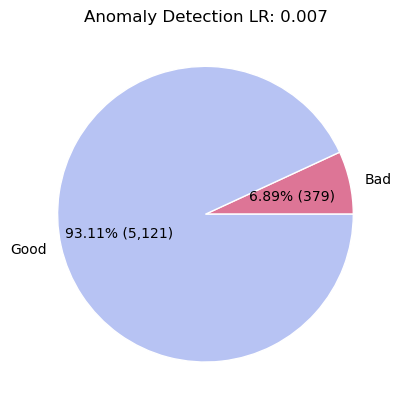

In [49]:
print(clean_count, poisoned_count)
# Data
labels = ['Bad', 'Good']
sizes = [poisoned_count, clean_count]
colors = ['#DD7596', '#B7C3F3']

# Create pie chart
plt.pie(sizes, labels=labels, autopct=lambda p : '{:.2f}% ({:,.0f})'.format(p,p * sum(sizes)/100), wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors)

# Add a title
plt.title('Anomaly Detection LR: 0.007')

# Display the chart
plt.show()

In [145]:
del model
torch.cuda.empty_cache()